In [1]:
import data
import opt

from multiprocessing import Pool, cpu_count
import numpy as np
import matplotlib.pyplot as plt

# Preamble

## Functions

In [2]:
def test(X, Y, Sn, S, H, h, K, Cy, Cy_samp):
    err_H = np.zeros((len(EXPS)))
    err_S = np.zeros((len(EXPS)))
    err_H_coefs = np.zeros((len(EXPS)))

    norm_h = (H**2).sum()
    norm_A = (S**2).sum()
    assert np.allclose(h, data.obtain_filter_coefs(S, H, K)) # Care with normalization
    import warnings
    warnings.filterwarnings('ignore')

    for i, exp in enumerate(EXPS):

        if exp["cy"] == "real" or exp["cy"] == "non-st":
            Cy_exp = Cy
        elif exp["cy"] == "samp":
            Cy_exp = Cy_samp
        else:
            raise NotImplementedError("Choose either real or samp covariance")

        params = args[exp["cy"]].get(exp["func"], [])

        if "iter" in exp["func"]:
            kwargs = {"H_true": H, "S_true": S}
        else:
            kwargs = {}
        
        iter, H_est, S_est = getattr(opt, exp["func"])(X, Y, Sn, Cy_exp, params, **kwargs)

        err_H[i] = ((H - H_est)**2).sum()/norm_h
        err_S[i] = ((S - S_est)**2).sum()/norm_A
        #err_S[i] = (((S / norm_A) - S_est/(S_est**2).sum())**2).sum()

        # Binarization
        thres = (np.max(S_est) - np.min(S_est))/2
        S_est_bin = np.where(S_est > thres, 1., 0.)

        h_est = data.obtain_filter_coefs(S_est_bin, H_est, K)
        err_H_coefs[i] = ((h - h_est)**2).mean()
        #print(f"Function {f} took {iter} iterations on covariance {cy_use}")
        
    return err_H, err_S, err_H_coefs

In [3]:
def objective(p_n, M, K, eps):

    err_H = np.zeros((n_graphs, len(EXPS)))
    err_S = np.zeros((n_graphs, len(EXPS)))
    err_H_coefs = np.zeros((n_graphs, len(EXPS)))

    with Pool(processes = n_procs) as pool:

        results = []

        for i in range(n_graphs):

            X, Y, Cy, Cy_samp, H, S, Sn, h = data.gen_data(N, M, p_er, p_n, eps, K, neg_coefs=neg_coefs, sort_h=sort_h, norm_S=norm_S, norm_H=norm_H, pert_type=pert_type)

            res = pool.apply_async(test, args=[X, Y, Sn, S, H, h, K, Cy, Cy_samp])
            results.append(res)

        for i in range(n_graphs):

            err_H[i,:], err_S[i,:], err_H_coefs[i,:] = results[i].get()

    return {
        'med_H': np.median(err_H, 0),
        'std_H': np.std(err_H, 0),
        'mean_H': np.mean(err_H, 0),
        'mean_S': np.mean(err_S, 0),
        'med_S': np.median(err_S, 0),
        'std_S': np.std(err_S, 0),
        'med_H_coefs': np.median(err_H_coefs, 0),
        'std_H_coefs': np.std(err_H_coefs, 0),
        'mean_H_coefs': np.mean(err_H_coefs, 0)
    }

## Parameters

In [4]:
n_graphs = 32

N = 20
p_er = 0.2
norm_S = False
norm_H = False
sort_h = False
neg_coefs = False
pert_type = "rewire"

noise = [0., 0.01, 0.02, 0.03, 0.04, 0.05]
samples = [10, 20, 40, 100]
Ks = [2, 3, 4, 5, 6, 7]
eps_vals = [0.05, 0.1, 0.15, 0.2]
eps_vals = [0.1, 0.15, 0.2, 0.25, 0.3]

n_procs = min(cpu_count(), n_graphs)

p_n_default = 0.02 # Default values
M_default = 15
K_default = 4
eps_default = 0.2#0.1

max_iters = 10

## Experiments

In [5]:
"""
EXPS = [
    {
        "func": "estH_unpertS",
        "cy": "real", # not used, so not important
        "legend": "FI",
        "fmt": "o:"
    },
    {
        "func": "estH_denS",
        "cy": "real",
        "legend": "DENS-REAL",
        "fmt": "d-"
    },
    {
        "func": "estH_denS",
        "cy": "samp",
        "legend": "DENS-SAMP",
        "fmt": "s--"
    },
    {
        "func": "estH_iter",
        "stationary": False,
        "cy": "real", # not used, so not important
        "legend": "ITER-NONST",
        "fmt": "P:"
    },
    {
        "func": "estH_iter",
        "stationary": True,
        "cy": "real",
        "legend": "ITER-ST-REAL",
        "fmt": "X-"
    },
    {
        "func": "estH_iter",
        "stationary": True,
        "cy": "samp",
        "legend": "ITER-ST-SAMP",
        "fmt": "*--"
    },
    {
        "func": "estH_iter_rew",
        "stationary": False,
        "cy": "real", # not used, so not important
        "legend": "ITER-REW-NONST",
        "fmt": "p:"
    },
    {
        "func": "estH_iter_rew",
        "stationary": True,
        "cy": "real",
        "legend": "ITER-REW-ST-REAL",
        "fmt": "v-"
    },
    {
        "func": "estH_iter_rew",
        "stationary": True,
        "cy": "samp",
        "legend": "ITER-REW-ST-SAMP",
        "fmt": "^--"
    }
]
"""
EXPS = [
    {
        "func": "estH_unpertS",
        "cy": "real", # not used, so not important
        "legend": "FI",
        "fmt": "o:"
    },
    {
        "func": "estH_denS",
        "cy": "real",
        "legend": "DENS-REAL",
        "fmt": "d-"
    },
    {
        "func": "estH_iter",
        "cy": "non-st",
        "legend": "ITER-NONST",
        "fmt": "P:"
    },
    {
        "func": "estH_iter",
        "stationary": True,
        "cy": "real",
        "legend": "ITER-ST-REAL",
        "fmt": "X-"
    },
    {
        "func": "estH_iter_rew",
        "cy": "non-st",
        "legend": "ITER-REW-NONST",
        "fmt": "p:"
    },
    {
        "func": "estH_iter_rew",
        "stationary": True,
        "cy": "real",
        "legend": "ITER-REW-ST-REAL",
        "fmt": "v-"
    },
]

## Hyperparameters

In [6]:
# Alternative
args = {
    'non-st': {
        'estH_denS': [1, 0.], #[gamma, delta],
        'estH_iter': [1, 0.01, 0., 1.1], #[lambd, gamma, delta, inc_gamma],
        'estH_iter_rew': [1, 0.1, 0., 0., 1.1] #[lambd, gamma, delta, beta, inc_gamma]
    },
    'real': {
        'estH_denS': [1, 0.1], #[gamma, delta],
        'estH_iter': [1, 0.1, 1, 1.1], #[lambd, gamma, delta, inc_gamma],
        'estH_iter_rew': [1, 1, 0.1, 0.01, 1.1] #[lambd, gamma, delta, beta, inc_gamma]
    }, 
    'samp': {
        'estH_denS': [0.1, 1], #[gamma, delta_samp],
        'estH_iter': [1, 0.001, 0.01, 1.1], #[lambd, gamma, delta, inc_gamma],
        'estH_iter_rew': [1, 0.01, 0.0001, 0.01, 1.1] #[lambd, gamma, delta, beta, inc_gamma]
    }
}

"\n# FOR THE CASE OF Normalized GSO\nargs_st = {\n    'real': {\n        'estH_denS': [0.1, 1], #[gamma, delta],\n        'estH_iter': [0.1, 1, 1, 1.1], #[lambd, gamma, delta, inc_gamma],\n        'estH_iter_rew': [0.1, 0.1, 1, 0.0001, 1.1] #[lambd, gamma, delta, beta, inc_gamma]\n    }, \n    'samp': {\n        'estH_denS': [0.1, 0.001], #[gamma, delta_samp],\n        'estH_iter': [1, 0.1, 0.001, 1.1], #[lambd, gamma, delta, inc_gamma],\n        'estH_iter_rew': [0.01, 0.01, 0.01, 0.0001, 1.1] #[lambd, gamma, delta, beta, inc_gamma]\n    }\n}\nargs_no_st = {\n    'real': {\n        'estH_denS': [0.1, 0], #[gamma, delta],\n        'estH_iter': [0.1, 1, 0, 1.1], #[lambd, gamma, delta, inc_gamma],\n        'estH_iter_rew': [0.1, 0.1, 0, 0.0001, 1.1] #[lambd, gamma, delta, beta, inc_gamma]\n    }, \n    'samp': {\n        'estH_denS': [0.1, 0.], #[gamma, delta_samp],\n        'estH_iter': [1, 0.1, 0., 1.1], #[lambd, gamma, delta, inc_gamma],\n        'estH_iter_rew': [0.01, 0.01, 0., 0.00

# Noise experiment

In [11]:
results_noise = {}
for n in noise:
    print(f"Starting {n}", flush=True)
    results_noise[n] = objective(n, M_default, K_default, eps_default)

Starting 0.0
Starting 0.01
Starting 0.02
Starting 0.03
Starting 0.04
Starting 0.05


Text(0.5, 0, 'Noise power')

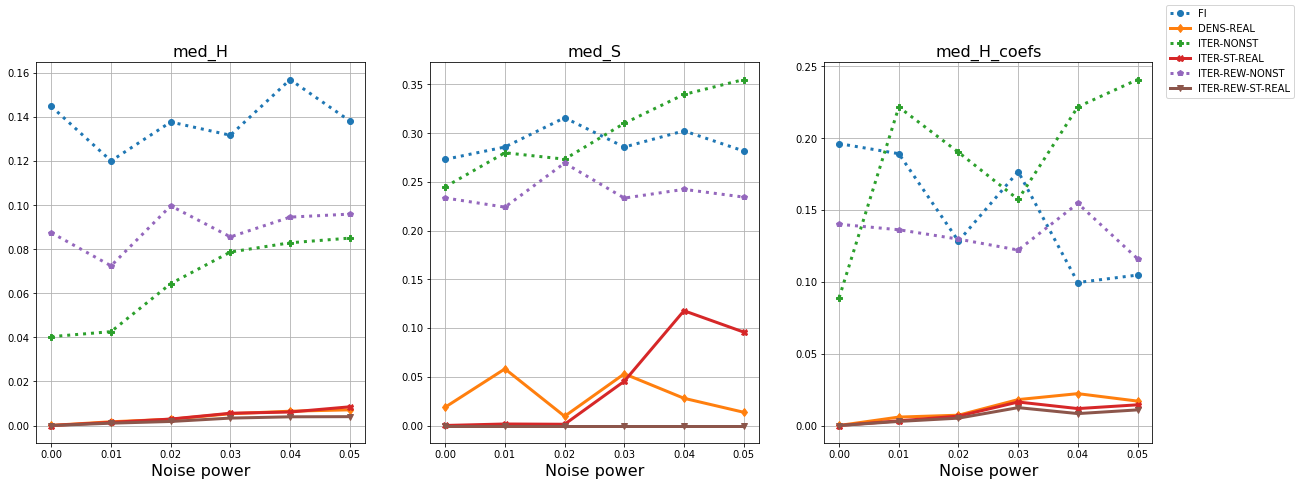

In [12]:
fig, ax = plt.subplots(1,3,figsize=(20,7))
metric = "med"
param_0 = metric + '_H'
param_1 = metric + '_S'
param_2 = metric + '_H_coefs'
for i, exp in enumerate(EXPS):
    ax[0].plot(noise, [r[param_0][i] for r in results_noise.values()], exp["fmt"], linewidth=3)
    ax[1].plot(noise, [r[param_1][i] for r in results_noise.values()], exp["fmt"], linewidth=3)
    ax[2].plot(noise, [r[param_2][i] for r in results_noise.values()], exp["fmt"], linewidth=3)
fig.legend([exp["legend"] for exp in EXPS])
ax[0].set_title(param_0, fontsize=16)
ax[1].set_title(param_1, fontsize=16)
ax[2].set_title(param_2, fontsize=16)
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[0].set_xlabel("Noise power", fontsize=16)
ax[1].set_xlabel("Noise power", fontsize=16)
ax[2].set_xlabel("Noise power", fontsize=16)

# Samples experiment

In [13]:
results_samples = {}
for s in samples:
    print(f"Starting {s}", flush=True)
    results_samples[s] = objective(p_n_default, s, K_default, eps_default)

Starting 10
Starting 20
Starting 40
Starting 100


Text(0.5, 0, 'Number of samples')

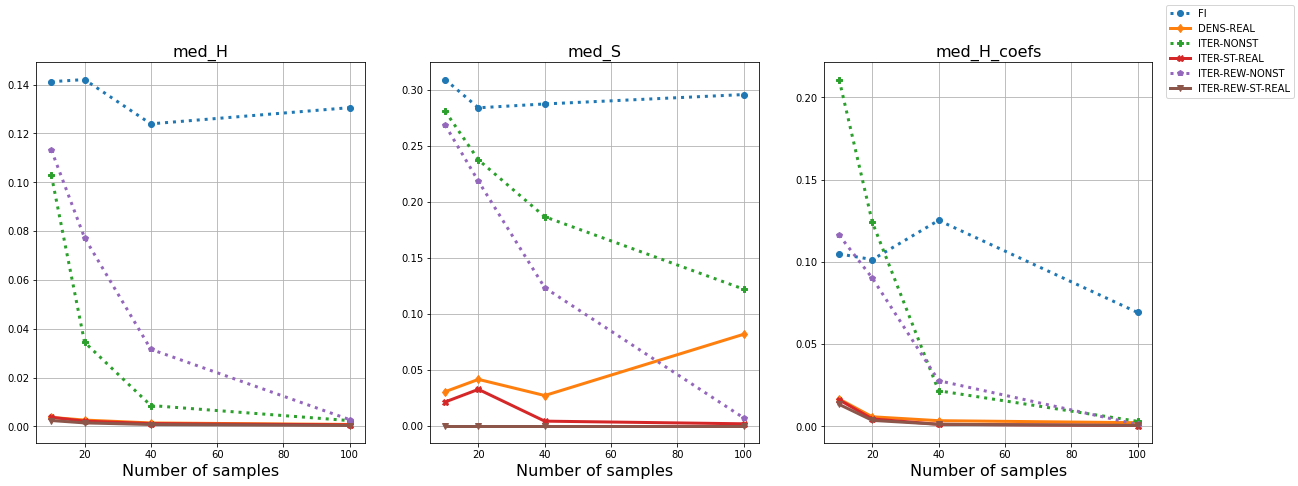

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(20,7))
metric = "med"
param_0 = metric + '_H'
param_1 = metric + '_S'
param_2 = metric + '_H_coefs'
for i, exp in enumerate(EXPS):
    ax[0].plot(samples, [r[param_0][i] for r in results_samples.values()], exp["fmt"], linewidth=3)
    ax[1].plot(samples, [r[param_1][i] for r in results_samples.values()], exp["fmt"], linewidth=3)
    ax[2].plot(samples, [r[param_2][i] for r in results_samples.values()], exp["fmt"], linewidth=3)
fig.legend([exp["legend"] for exp in EXPS])
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[0].set_title(param_0, fontsize=16)
ax[1].set_title(param_1, fontsize=16)
ax[2].set_title(param_2, fontsize=16)
ax[0].set_xlabel("Number of samples", fontsize=16)
ax[1].set_xlabel("Number of samples", fontsize=16)
ax[2].set_xlabel("Number of samples", fontsize=16)

# Filter order experiment

In [15]:
results_K = {}
for k in Ks:
    print(f"Starting {k}", flush=True)
    results_K[k] = objective(p_n_default, M_default, k, eps_default)

Starting 2
Starting 3
Starting 4
Starting 5
Starting 6
Starting 7


Text(0.5, 0, 'Filter order')

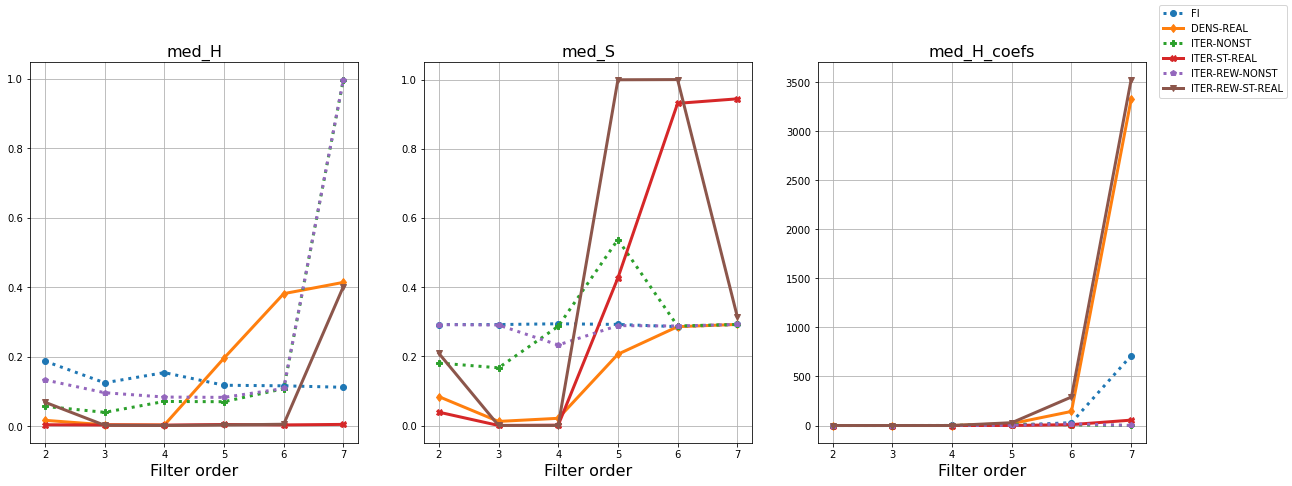

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(20,7))
metric = "med"
param_0 = metric + '_H'
param_1 = metric + '_S'
param_2 = metric + '_H_coefs'
for i, exp in enumerate(EXPS):
    ax[0].plot(Ks, [r[param_0][i] for r in results_K.values()], exp["fmt"], linewidth=3)
    ax[1].plot(Ks, [r[param_1][i] for r in results_K.values()], exp["fmt"], linewidth=3)
    ax[2].plot(Ks, [r[param_2][i] for r in results_K.values()], exp["fmt"], linewidth=3)
fig.legend([exp["legend"] for exp in EXPS])
ax[0].set_title(param_0, fontsize=16)
ax[1].set_title(param_1, fontsize=16)
ax[2].set_title(param_2, fontsize=16)
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[0].set_xlabel("Filter order", fontsize=16)
ax[1].set_xlabel("Filter order", fontsize=16)
ax[2].set_xlabel("Filter order", fontsize=16)

# Adjacency perturbation experiment

In [17]:
results_eps = {}
for eps in eps_vals:
    print(f"Starting {eps}", flush=True)
    results_eps[eps] = objective(p_n_default, M_default, K_default, eps)

Starting 0.1
Starting 0.15
Starting 0.2
Starting 0.25
Starting 0.3


Text(0.5, 0, 'Perturbation pct')

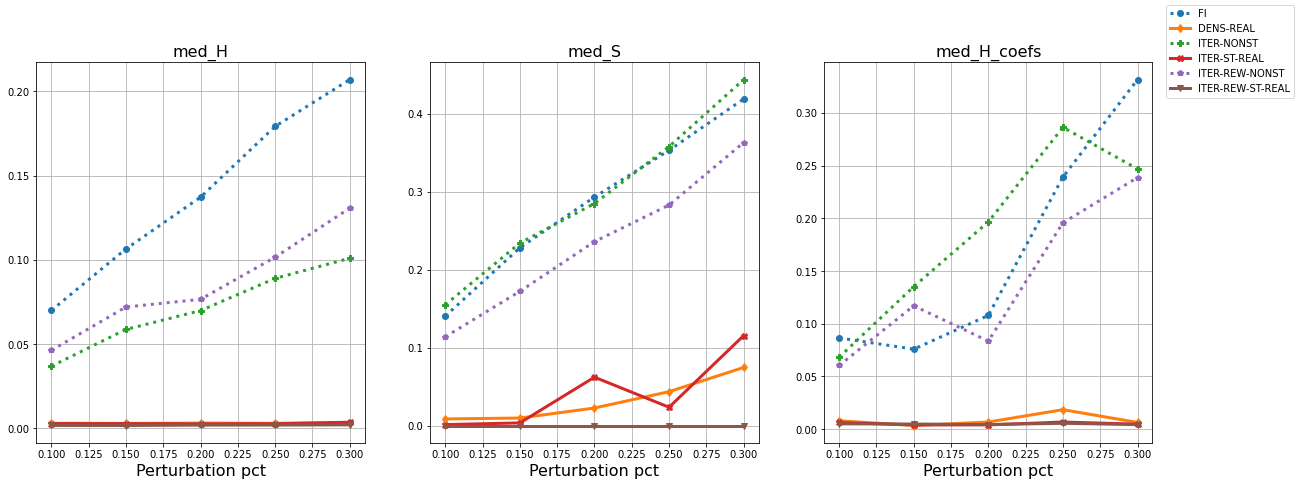

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(20,7))
metric = "med"
param_0 = metric + '_H'
param_1 = metric + '_S'
param_2 = metric + '_H_coefs'
for i, exp in enumerate(EXPS):
    ax[0].plot(eps_vals, [r[param_0][i] for r in results_eps.values()], exp["fmt"], linewidth=3)
    ax[1].plot(eps_vals, [r[param_1][i] for r in results_eps.values()], exp["fmt"], linewidth=3)
    ax[2].plot(eps_vals, [r[param_2][i] for r in results_eps.values()], exp["fmt"], linewidth=3)
fig.legend([exp["legend"] for exp in EXPS])
ax[0].set_title(param_0, fontsize=16)
ax[1].set_title(param_1, fontsize=16)
ax[2].set_title(param_2, fontsize=16)
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[0].set_xlabel("Perturbation pct", fontsize=16)
ax[1].set_xlabel("Perturbation pct", fontsize=16)
ax[2].set_xlabel("Perturbation pct", fontsize=16)